In [45]:
import pandas as pd
df = pd.read_excel("complete nutrients data.xlsx")   # adjust path if needed
df.shape, df.columns
df.head()

,District,Block,n_High,n_Medium,n_Low,p_High,p_Medium,p_Low,k_High,k_Medium,...,Fe_Sufficient,Fe_Deficient,Zn_Sufficient,Zn_Deficient,Cu_Sufficient,Cu_Deficient,B_Sufficient,B_Deficient,Mn_Sufficient,Mn_Deficient
0,HANUMAKONDA,ATMAKUR,0.00,0.00,100.00,82.93,17.07,0.00,98.37,1.63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,HANUMAKONDA,BHEEMADEVARAPALLI,0.00,0.00,100.00,84.47,14.56,0.97,88.35,11.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HANUMAKONDA,Damera,0.00,8.62,91.38,94.83,5.17,0.00,93.10,6.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HANUMAKONDA,DHARMASAGAR,3.22,11.24,85.54,93.76,6.17,0.07,92.73,7.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HANUMAKONDA,ELKATHURTHI,0.00,32.04,67.96,84.47,15.53,0.00,75.73,24.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# check missing values
df.isna().sum()

# view unique District/Block values for dropdown later
districts = sorted(df['District'].dropna().unique())
blocks_per_district = df.groupby('District')['Block'].unique().to_dict()

In [47]:
df = df.drop_duplicates().reset_index(drop=True)
df.columns = [c.strip().replace(" ", "_") for c in df.columns]


In [48]:
def dominant_value(row, nutrient):
    # returns "High"/"Medium"/"Low"
    candidates = { 'High': row.get(f"{nutrient}_High", 0),
                   'Medium': row.get(f"{nutrient}_Medium", 0),
                   'Low': row.get(f"{nutrient}_Low", 0)}
    return max(candidates, key=candidates.get)

map_score = {'High':2, 'Medium':1, 'Low':0}
for n in ['n','p','k','OC']:
    df[f"{n}_cat"] = df.apply(lambda r: dominant_value(r, n), axis=1)
    df[f"{n}_score"] = df[f"{n}_cat"].map(map_score)

# pH numeric
df['pH_status'] = df[['pH_Alkaline','pH_Acidic','pH_Neutral']].idxmax(axis=1)
df['is_saline'] = (df['EC_Saline'] > df['EC_NonSaline']).astype(int)

# Example: target creation
# If you already have a "recommended_crop" column, use it as target.
# Otherwise you can create a rule-based label for training (see below).


In [49]:
def rule_label(row, temp):
    fert_class = 'High' if row[['n_score','p_score','k_score','OC_score']].sum() >= 6 else \
                 'Medium' if row[['n_score','p_score','k_score','OC_score']].sum() >= 3 else 'Low'
    # pseudo rules:
    if 20 <= temp <= 35 and fert_class in ['High','Medium']:
        return 'Paddy'
    elif 18 <= temp <= 32 and fert_class in ['High','Medium']:
        return 'Maize'
    elif 25 <= temp <= 42:
        return 'Millets'
    else:
        return 'Local_crop'

# Expand dataset across sample temperatures for training
temps = list(range(15,36))
rows = []
for _, r in df.iterrows():
    for t in temps:
        new = r.copy()
        new['temperature'] = t
        new['label_crop'] = rule_label(r, t)
        rows.append(new)
train_df = pd.DataFrame(rows)


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import joblib

# pick features
features = ['n_score','p_score','k_score','OC_score','is_saline','temperature']  # add more as needed
X = train_df[features]
y = train_df['label_crop']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# save model
joblib.dump(model, "crop_recommender_rf.joblib")


              precision    recall  f1-score   support

  Local_crop       1.00      0.99      0.99       190
       Maize       0.98      1.00      0.99       126
     Millets       1.00      1.00      1.00        17
       Paddy       1.00      1.00      1.00      1003

    accuracy                           1.00      1336
   macro avg       1.00      1.00      1.00      1336
weighted avg       1.00      1.00      1.00      1336



['crop_recommender_rf.joblib']

In [51]:
base_fert = {
    "Paddy": {"N":100,"P2O5":50,"K2O":40},
    "Maize": {"N":120,"P2O5":60,"K2O":40},
    # ...
}
def fert_for_crop(row, crop):
    mult_map = {0:1.0, 1:0.7, 2:0.5}   # using scores 0/1/2
    return {
        'N': round(base_fert[crop]['N'] * mult_map[row['n_score']],1),
        'P2O5': round(base_fert[crop]['P2O5'] * mult_map[row['p_score']],1),
        'K2O': round(base_fert[crop]['K2O'] * mult_map[row['k_score']],1)
    }


In [52]:
import joblib
model = joblib.load("crop_recommender_rf.joblib")

sample = X_test.iloc[0:5]
preds = model.predict(sample)
sample.assign(predicted_crop=preds)


,n_score,p_score,k_score,OC_score,is_saline,temperature,predicted_crop
154,0,2,2,1,0,29,Paddy
219,0,2,1,0,0,17,Local_crop
283,0,2,2,0,0,23,Paddy
74,0,2,0,1,0,23,Paddy
77,0,2,1,1,0,15,Local_crop


In [53]:
# Example fertilizer base values per crop
base_fert = {
    'Paddy': {'N': 100, 'P2O5': 25, 'K2O': 20},
    'Maize': {'N': 120, 'P2O5': 40, 'K2O': 30},
    'Local_crop': {'N': 90, 'P2O5': 20, 'K2O': 25}
}

def fert_for_crop(row, crop):
    mult_map = {0: 1.0, 1: 0.7, 2: 0.5}
    return {
        'N': round(base_fert[crop]['N'] * mult_map[row['n_score']], 1),
        'P2O5': round(base_fert[crop]['P2O5'] * mult_map[row['p_score']], 1),
        'K2O': round(base_fert[crop]['K2O'] * mult_map[row['k_score']], 1)
    }

# Predict for each sample row
for idx, row in sample.iterrows():
    crop = model.predict(pd.DataFrame([row], columns=X.columns))[0]   # ✅ keep feature names
    print(crop, fert_for_crop(row, crop))



Paddy {'N': 100.0, 'P2O5': 12.5, 'K2O': 10.0}
Local_crop {'N': 90.0, 'P2O5': 10.0, 'K2O': 17.5}
Paddy {'N': 100.0, 'P2O5': 12.5, 'K2O': 10.0}
Paddy {'N': 100.0, 'P2O5': 12.5, 'K2O': 20.0}
Local_crop {'N': 90.0, 'P2O5': 10.0, 'K2O': 17.5}


In [54]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


In [55]:
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=500),
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    results[name] = acc

results


c:\Users\Hp\nutrients data\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.9625748502994012,
 'KNN': 0.9932634730538922,
 'SVM': 0.9782934131736527,
 'Decision Tree': 0.9985029940119761,
 'Random Forest': 0.9985029940119761,
 'Naive Bayes': 0.32335329341317365,
 'Neural Network': 1.0}

In [56]:
import pandas as pd
df = pd.read_excel("complete nutrients data.xlsx")   # adjust path if needed
df.shape, df.columns
df.head()

,District,Block,n_High,n_Medium,n_Low,p_High,p_Medium,p_Low,k_High,k_Medium,...,Fe_Sufficient,Fe_Deficient,Zn_Sufficient,Zn_Deficient,Cu_Sufficient,Cu_Deficient,B_Sufficient,B_Deficient,Mn_Sufficient,Mn_Deficient
0,HANUMAKONDA,ATMAKUR,0.00,0.00,100.00,82.93,17.07,0.00,98.37,1.63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,HANUMAKONDA,BHEEMADEVARAPALLI,0.00,0.00,100.00,84.47,14.56,0.97,88.35,11.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HANUMAKONDA,Damera,0.00,8.62,91.38,94.83,5.17,0.00,93.10,6.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HANUMAKONDA,DHARMASAGAR,3.22,11.24,85.54,93.76,6.17,0.07,92.73,7.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HANUMAKONDA,ELKATHURTHI,0.00,32.04,67.96,84.47,15.53,0.00,75.73,24.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
df.columns.tolist()


['District',
 'Block',
 'n_High',
 'n_Medium',
 'n_Low',
 'p_High',
 'p_Medium',
 'p_Low',
 'k_High',
 'k_Medium',
 'k_Low',
 'OC_High',
 'OC_Medium',
 'OC_Low',
 'pH_Alkaline',
 'pH_Acidic',
 'pH_Neutral',
 'EC_NonSaline',
 'EC_Saline',
 'S_Sufficient',
 'S_Deficient',
 'Fe_Sufficient',
 'Fe_Deficient',
 'Zn_Sufficient',
 'Zn_Deficient',
 'Cu_Sufficient',
 'Cu_Deficient',
 'B_Sufficient',
 'B_Deficient',
 'Mn_Sufficient',
 'Mn_Deficient']

In [58]:
from sklearn.model_selection import train_test_split


In [59]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


NameError: name 'categorical_cols' is not defined

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Define which columns are categorical
categorical_cols = ["District", "Block"]  # add more if needed

# Step 2: Label Encode
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


In [ ]:
X = df.drop("District", axis=1)
y = df["District"]


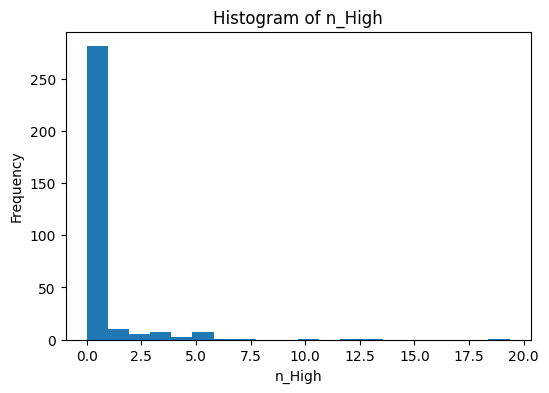

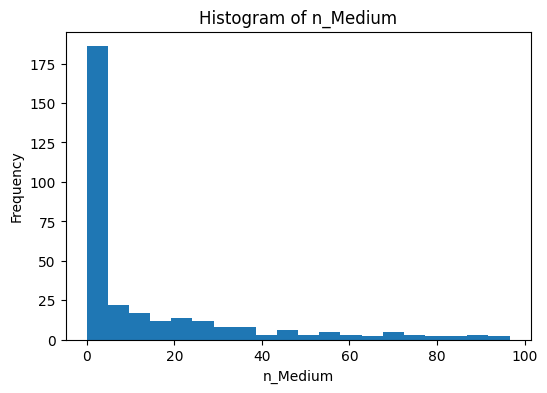

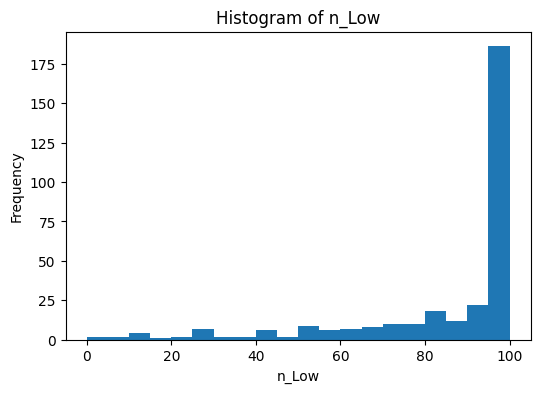

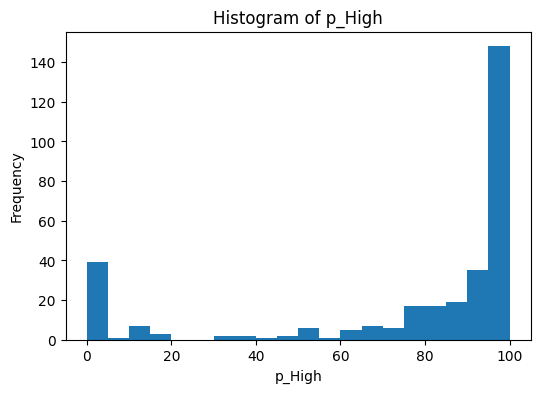

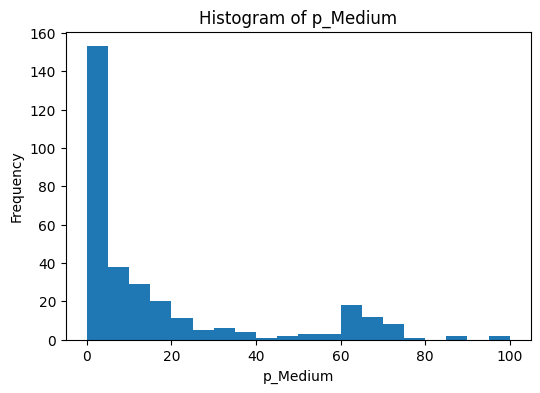

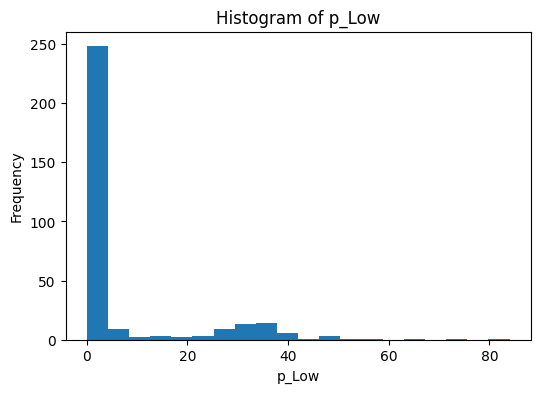

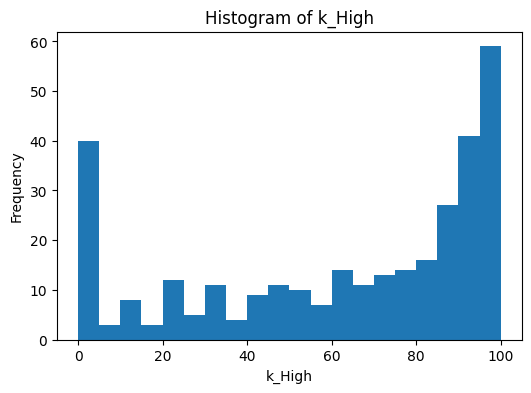

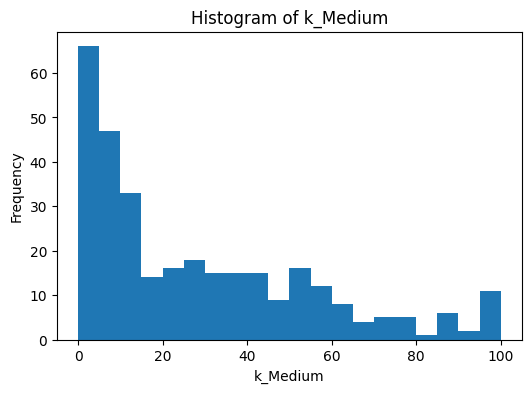

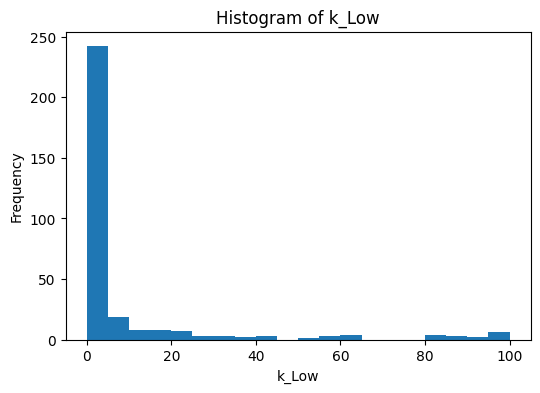

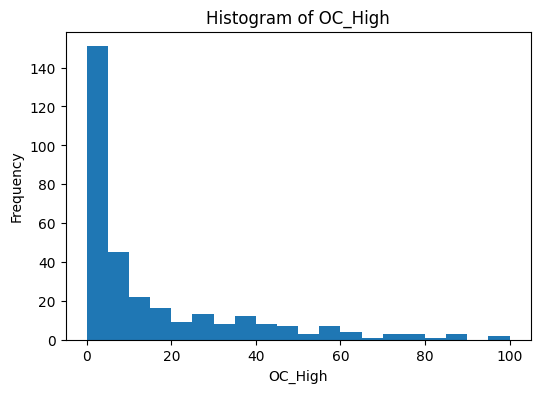

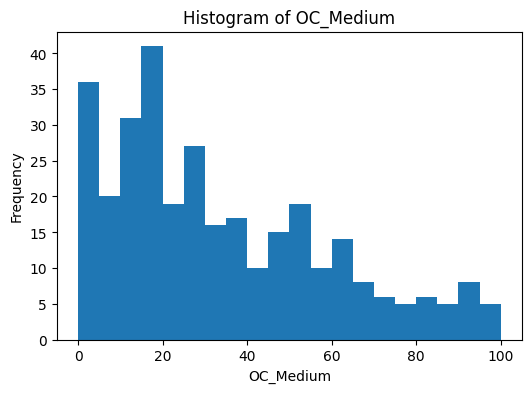

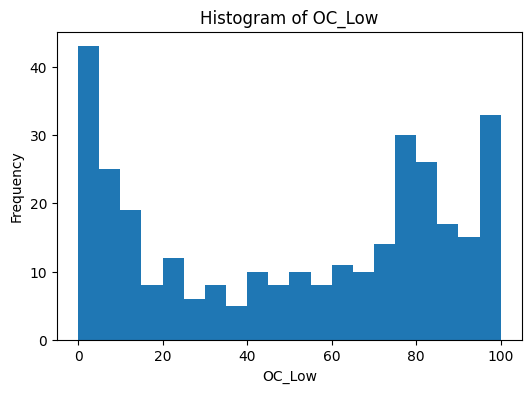

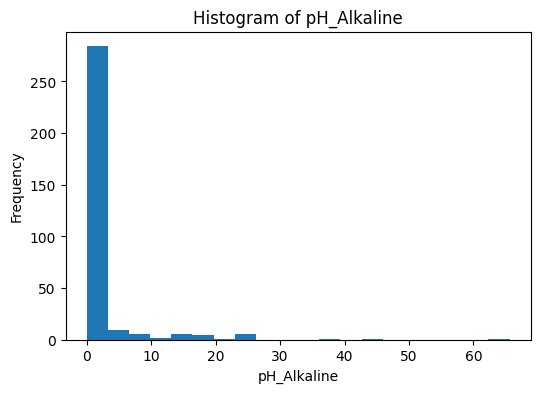

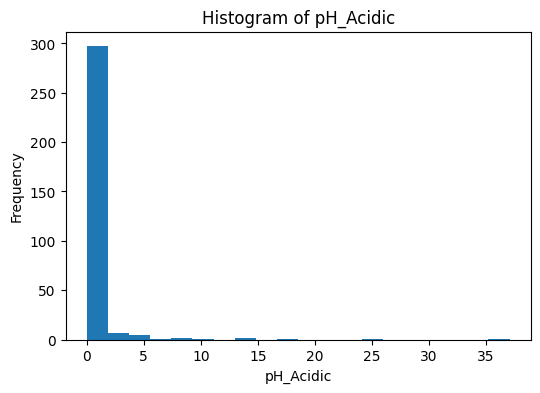

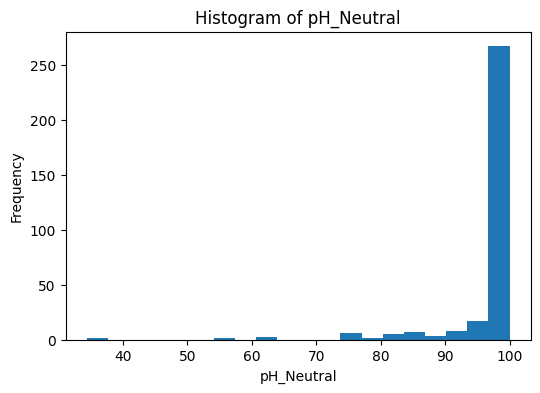

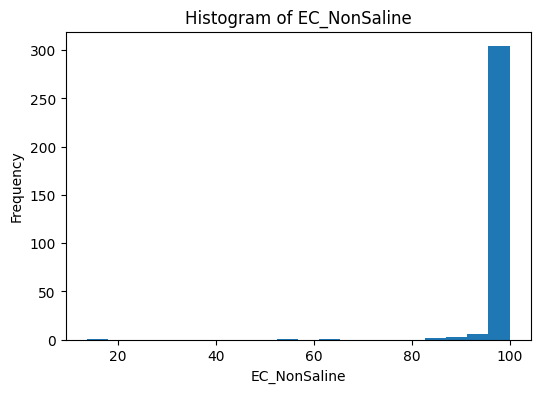

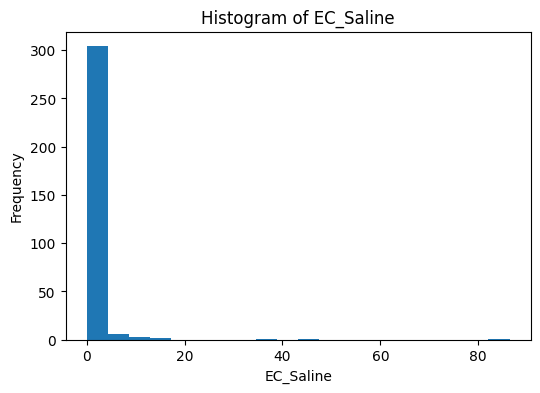

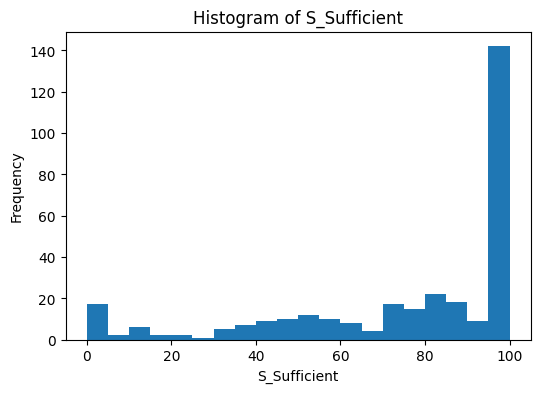

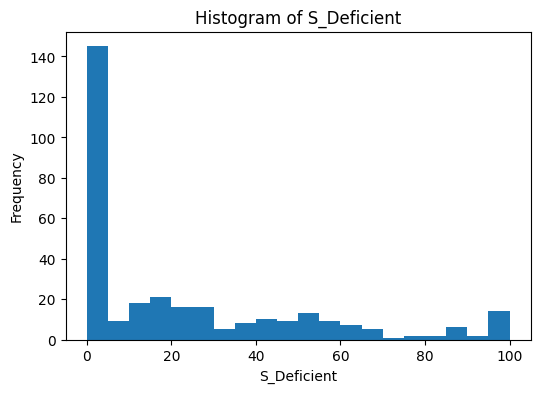

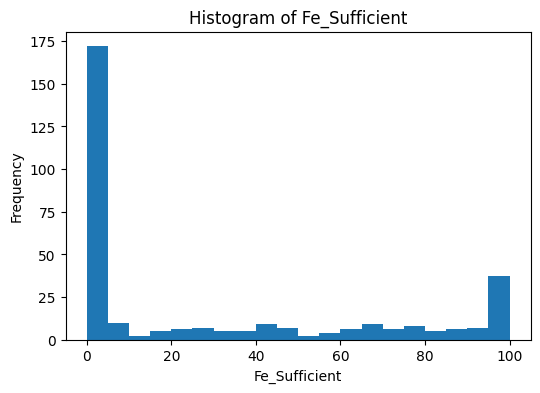

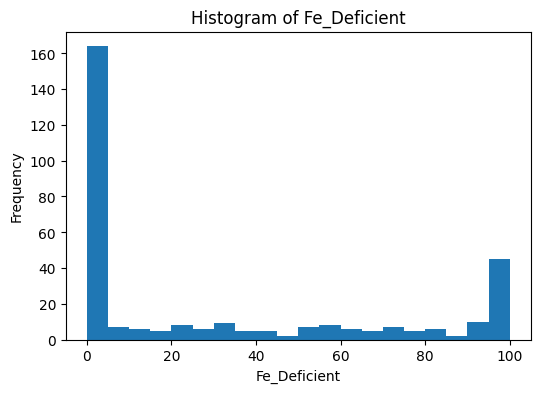

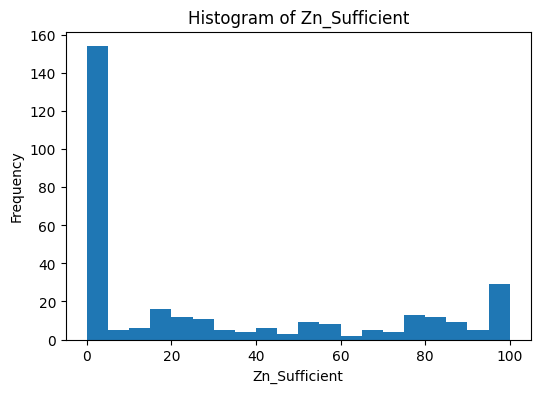

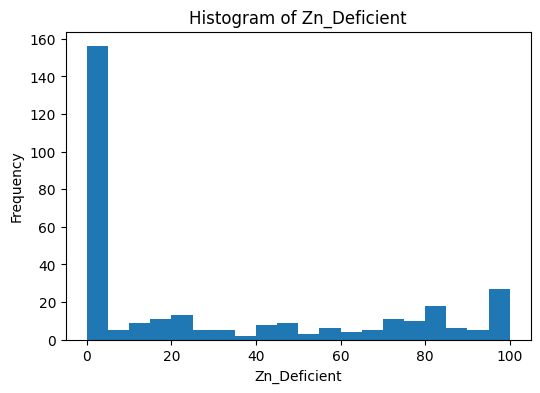

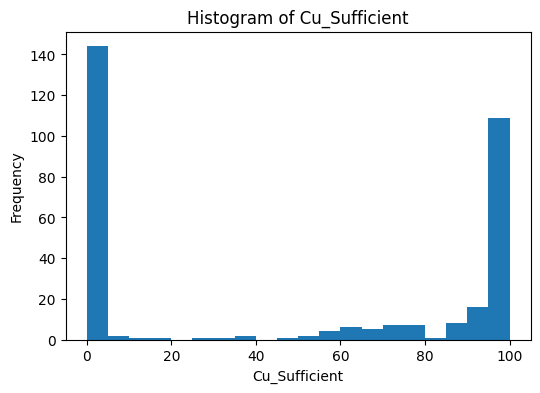

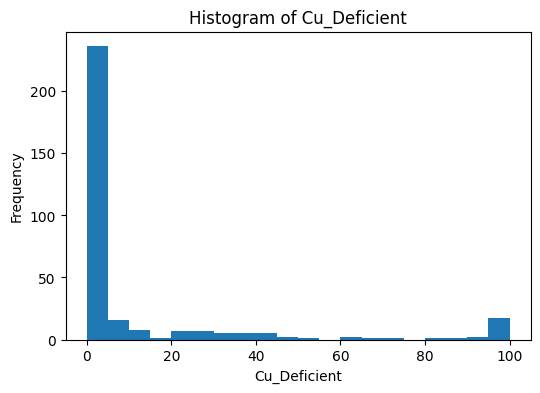

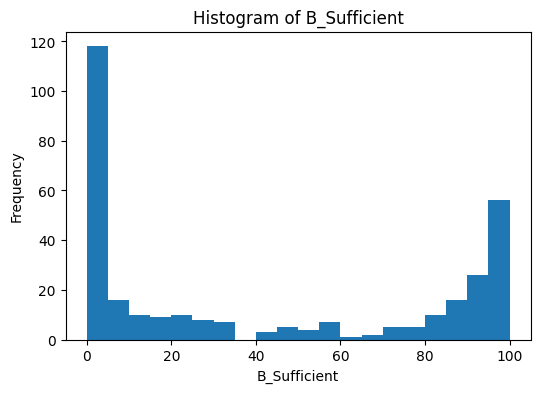

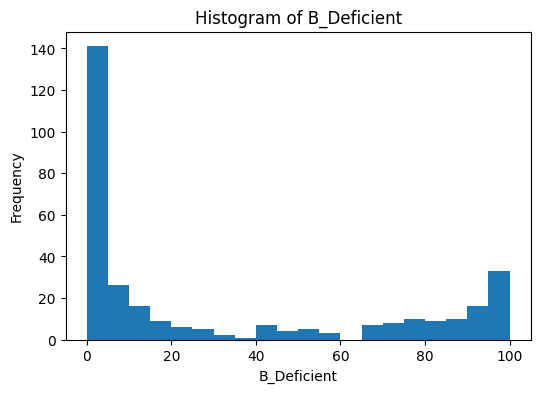

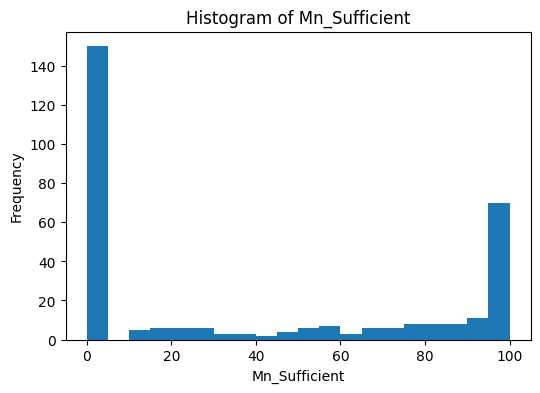

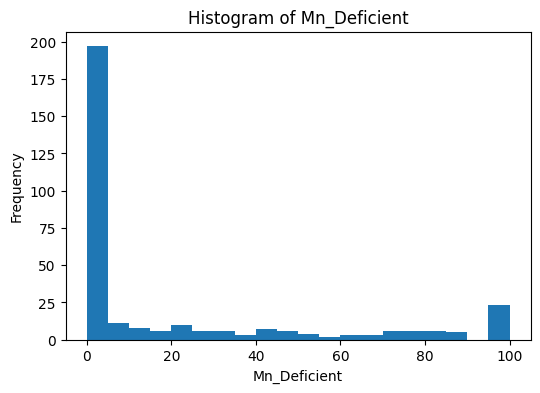

In [ ]:
import matplotlib.pyplot as plt

for col in df.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=20)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


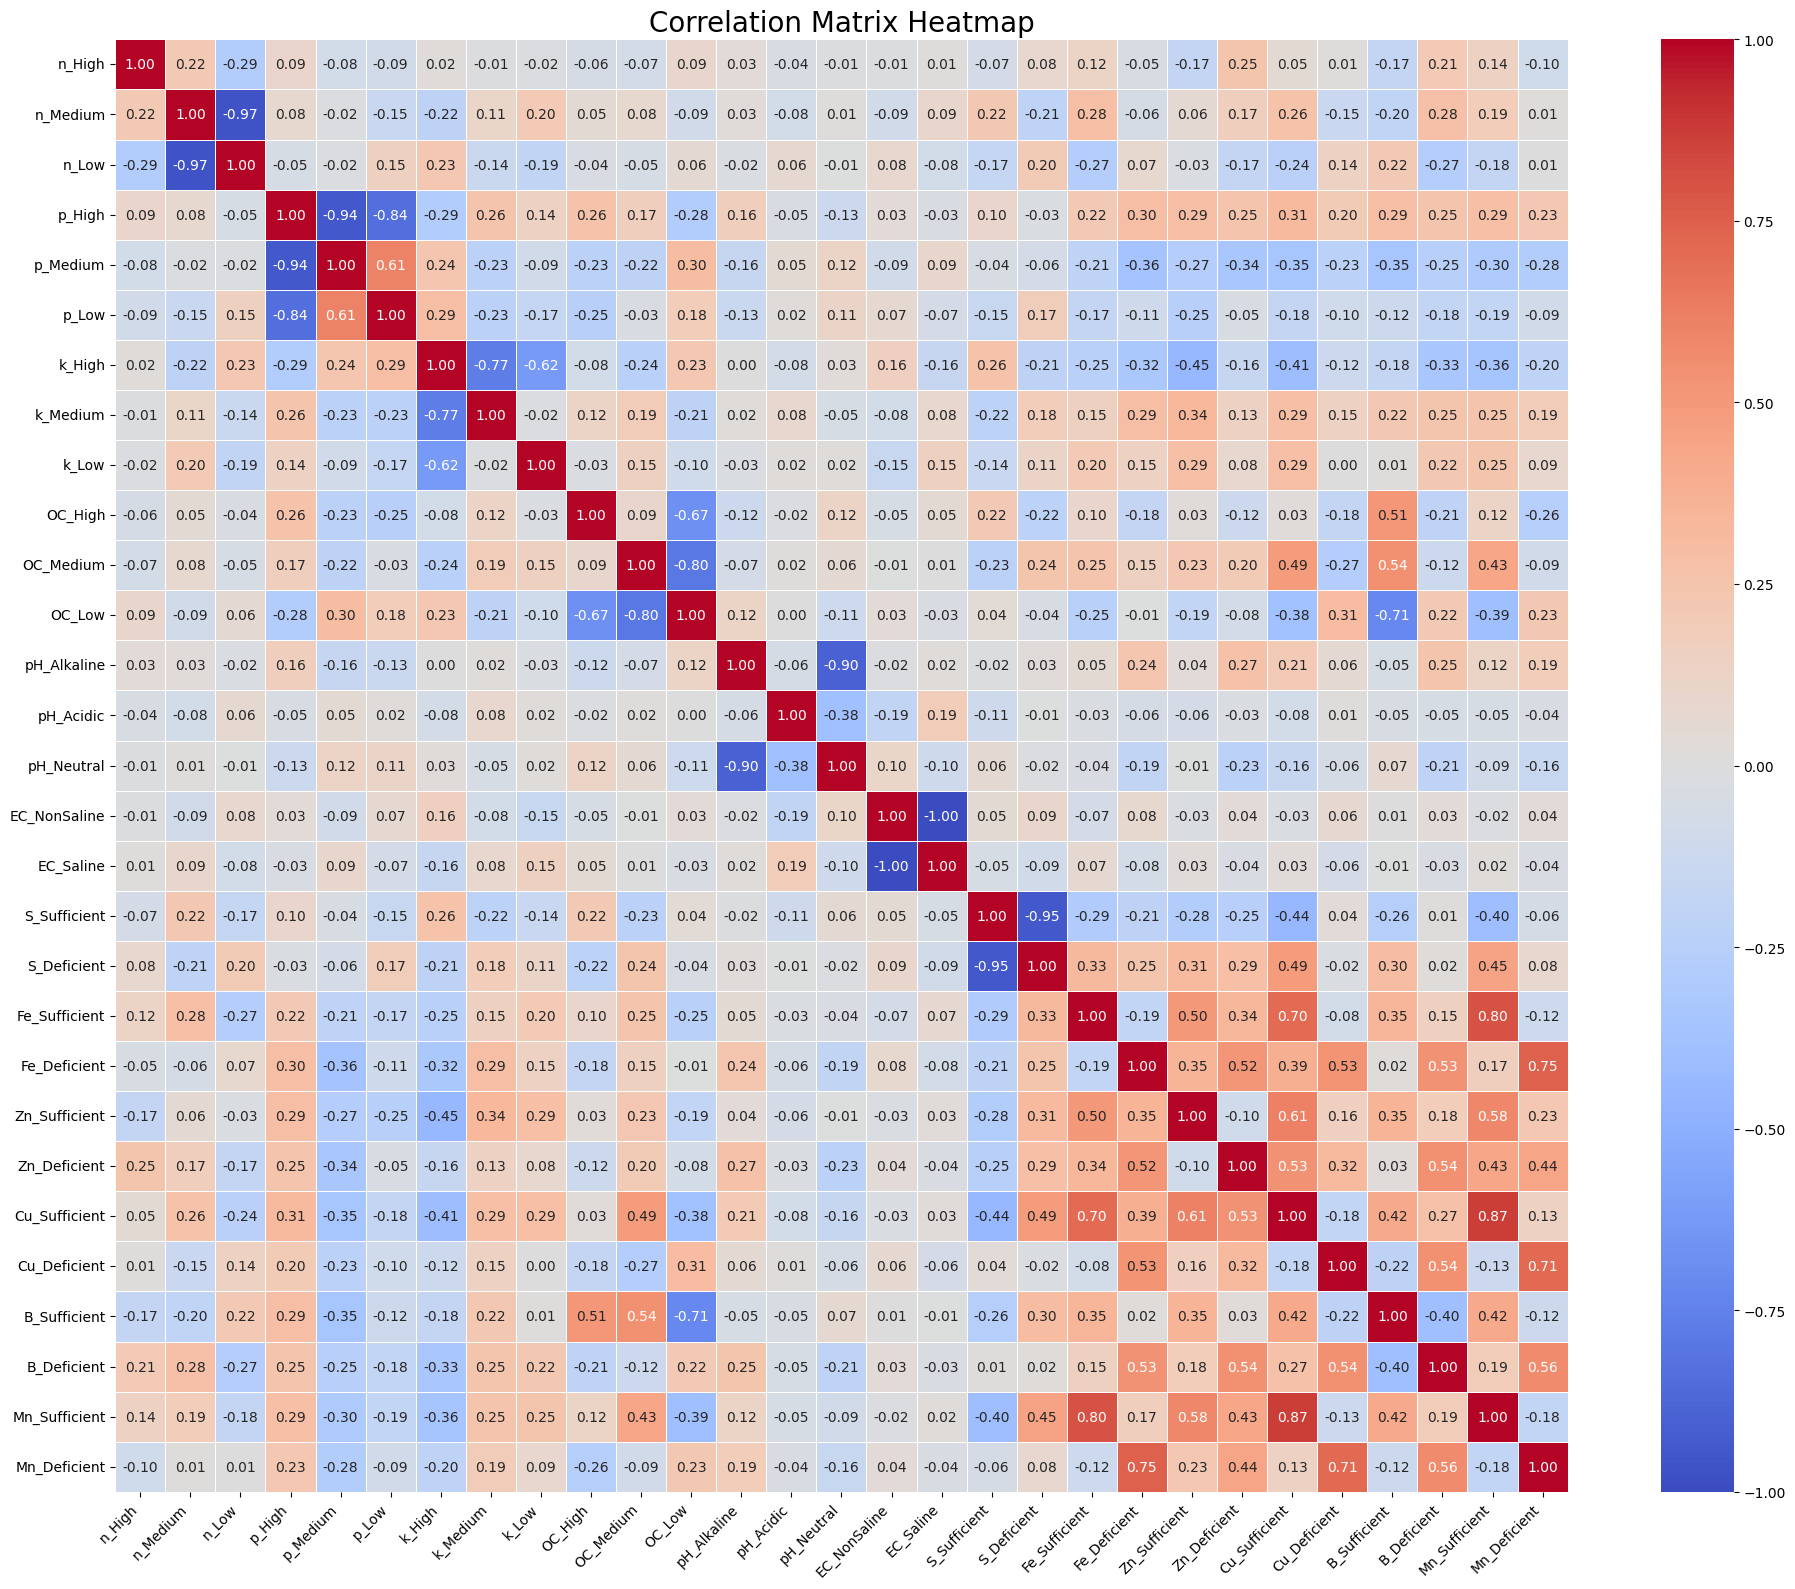

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 16))  # make the figure bigger
sns.heatmap(df.corr(numeric_only=True), 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            square=True, 
            linewidths=0.5)  # add lines to separate cells

plt.title("Correlation Matrix Heatmap", fontsize=20)
plt.xticks(rotation=45, ha='right')  # rotate x labels
plt.yticks(rotation=0)               # y labels horizontal
plt.tight_layout()
plt.show()


   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


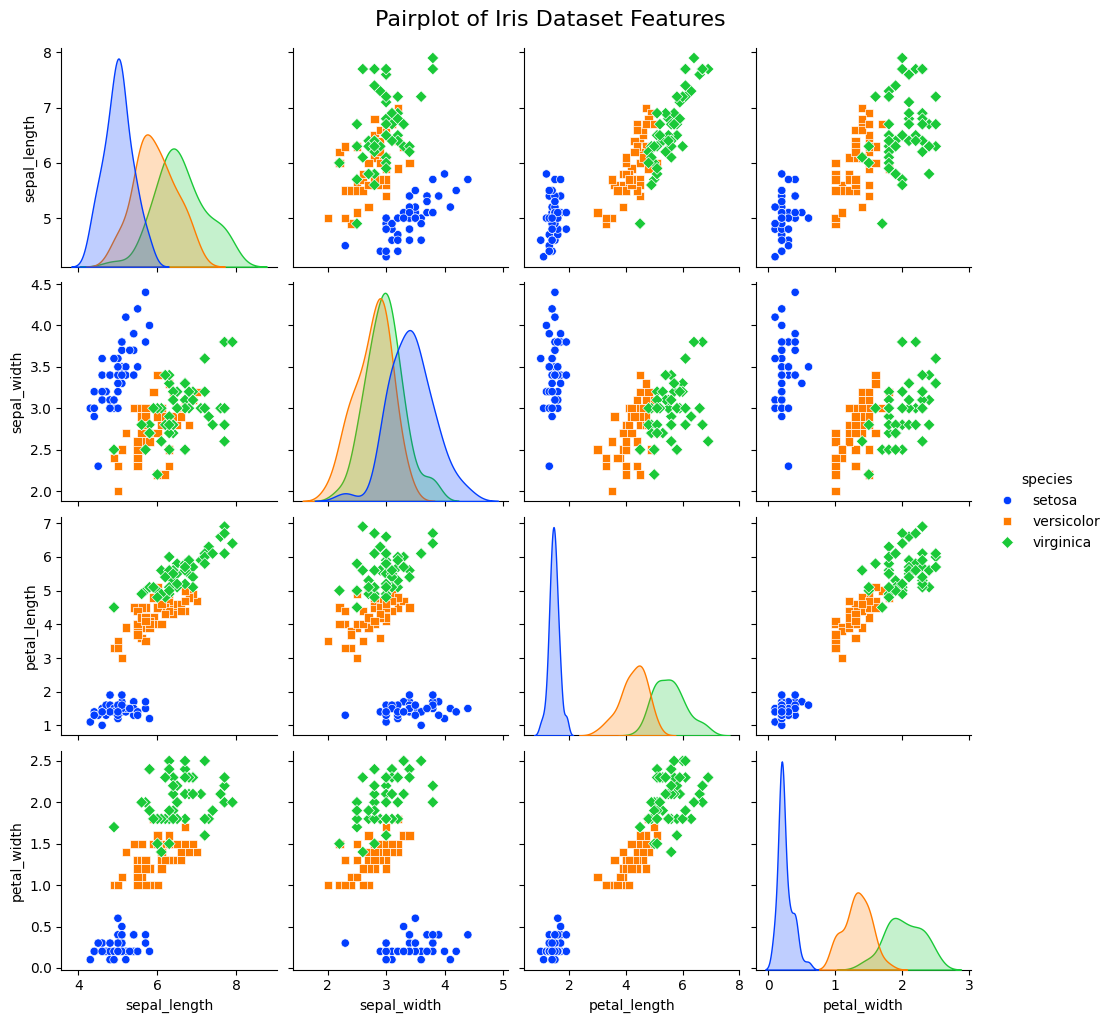

In [ ]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example dataset: Iris
df = sns.load_dataset('iris')  # You can replace this with your own CSV: pd.read_csv('yourfile.csv')

# Display first few rows
print(df.head())

# Creating the pairplot
sns.pairplot(df, 
             hue='species',  # Column to color by
             diag_kind='kde',  # Kernel Density Estimate on the diagonal
             markers=['o', 's', 'D'],  # Different marker shapes for each class
             palette='bright')  # Color palette

# Adding titles and labels manually (optional)
plt.suptitle('Pairplot of Iris Dataset Features', y=1.02, fontsize=16)
plt.show()


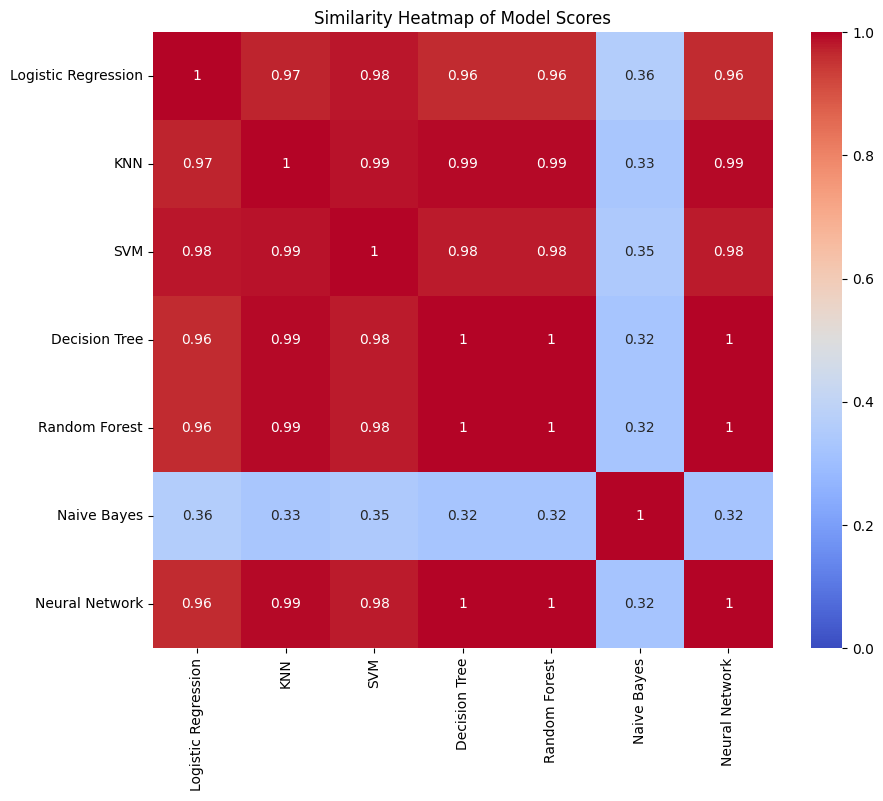

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Model accuracy values
model_scores = {
    'Logistic Regression': 0.9625748502994012,
    'KNN': 0.9932634730538922,
    'SVM': 0.9782934131736527,
    'Decision Tree': 0.9985029940119761,
    'Random Forest': 0.9985029940119761,
    'Naive Bayes': 0.32335329341317365,
    'Neural Network': 1.0
}

models = list(model_scores.keys())
scores = np.array(list(model_scores.values()))

# Create a "similarity matrix" based on absolute differences
similarity = 1 - np.abs(scores[:, None] - scores[None, :])

# Convert to DataFrame
sim_df = pd.DataFrame(similarity, index=models, columns=models)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Similarity Heatmap of Model Scores")
plt.show()


In [ ]:
import pandas as pd
df = pd.read_excel("soil_recommendations_expanded.xlsx")   # adjust path if needed
df.shape, df.columns
df.head()

,District,Block,Temperature_C,Soil_Fertility,Recommended_Crops,Fertilizer_Recommendations,ZnSO4_kg_per_acre,Gypsum_kg_per_acre,N_status,P_status,K_status,OC_status,pH_status,EC_status
0,HANUMAKONDA,ATMAKUR,10,Medium,NaN,{},0,0,Low,High,High,Low,Neutral,NonSaline
1,HANUMAKONDA,ATMAKUR,11,Medium,NaN,{},0,0,Low,High,High,Low,Neutral,NonSaline
2,HANUMAKONDA,ATMAKUR,12,Medium,NaN,{},0,0,Low,High,High,Low,Neutral,NonSaline
3,HANUMAKONDA,ATMAKUR,13,Medium,NaN,{},0,0,Low,High,High,Low,Neutral,NonSaline
4,HANUMAKONDA,ATMAKUR,14,Medium,NaN,{},0,0,Low,High,High,Low,Neutral,NonSaline


In [ ]:
# check missing values
df.isna().sum()

# view unique District/Block values for dropdown later
districts = sorted(df['District'].dropna().unique())
blocks_per_district = df.groupby('District')['Block'].unique().to_dict()

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
df.columns = [c.strip().replace(" ", "_") for c in df.columns]
